In [1]:
import json
#from google.colab import drive

# Get the notebook's filename (usually matches the GitHub repo name)
!ls *.ipynb
notebook_name = "NLPProject.ipynb"  # ← Replace with your filename

# Load and fix the notebook
with open(notebook_name, 'r') as f:
    nb = json.load(f)

# Option A: Remove widgets metadata completely (recommended)
if 'metadata' in nb and 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

# Option B: Or add the missing state key
# if 'metadata' in nb and 'widgets' in nb['metadata']:
#     nb['metadata']['widgets']['state'] = {}

# Save the fixed version
with open(notebook_name, 'w') as f:
    json.dump(nb, f)

print("Notebook metadata fixed! You can now commit to GitHub.")

NLPProject.ipynb  NLPProject3.ipynb place_FE.ipynb
NLPProject2.ipynb manner_FE.ipynb
Notebook metadata fixed! You can now commit to GitHub.


In [2]:
from pprint import pprint
from operator import itemgetter
import nltk
from nltk.corpus import framenet as fn
from nltk.corpus.reader.framenet import PrettyList
nltk.download('framenet_v17')

[nltk_data] Downloading package framenet_v17 to
[nltk_data]     /Users/kierstenwener/nltk_data...
[nltk_data]   Package framenet_v17 is already up-to-date!


True

In [3]:
frames_with_place_ex = {}
for f in fn.frames():
    for x in f.FE:
        if x == "Place":
            frames_with_place_ex[f.name] = f

In [4]:
def align_labels_with_tokens(text, char_labels, offsets):
    token_labels = []
    for start, end in offsets:
        if start == end:
            token_labels.append("O")  # Special tokens like [CLS], [SEP]
        else:
            # Majority vote over character labels inside the token span
            span_labels = char_labels[start:end]
            if all(lab == "O" for lab in span_labels):
                token_labels.append("O")
            elif span_labels[0] == "B-Place":
                token_labels.append("B-Place")
            else:
                token_labels.append("I-Place")
    return token_labels

In [5]:
import torch
from nltk.corpus import framenet as fn
from transformers import BertTokenizerFast

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Map BIO tags to IDs
label2id = {"O": 0, "B-Place": 1, "I-Place": 2}
input_ids_list = []
attention_masks_list = []
labels_list = []

# Find frames that include "Place" as a frame element

for name, frame in frames_with_place_ex.items():
    # Print the frame name for reference
    for lu in frame.lexUnit.values():
        #print(f"\nLexical Unit: {lu['name']}")
        lu_data = fn.lu(lu['ID'])
        for ex in lu_data['exemplars']:
            text = ex['text']
            char_labels = ["O"] * len(text)
            has_place_fe = False

            for fe in ex['FE']:
                for i in fe:
                    if i[2] == "Place":
                        start, end = i[0], i[1]
                        if start < end:
                            char_labels[start] = "B-Place"
                            for i in range(start+1, end):
                                char_labels[i] = "I-Place"
                            has_place_fe = True
            if not has_place_fe:
                continue


            # Tokenize
            tokenized = tokenizer(text, return_offsets_mapping=True, truncation=True, padding="max_length", max_length=128)
            input_ids = tokenized["input_ids"]
            attention_mask = tokenized["attention_mask"]
            offsets = tokenized["offset_mapping"]

            # Map character-level labels to token-level labels
            token_labels = align_labels_with_tokens(text, char_labels, offsets)
            label2id_binary = {"O": 0, "B-Place": 1, "I-Place": 2}  
            # Pad remaining labels with -100 where attention mask is 0 (i.e., padding tokens)


            label_ids = [label2id_binary.get(lab, 0) for lab in token_labels]
            label_ids = [
                label if mask == 1 else -100 
                for label, mask in zip(label_ids, attention_mask)
            ]
            # Store tensors
            input_ids_list.append(torch.tensor(input_ids))
            attention_masks_list.append(torch.tensor(attention_mask))
            labels_list.append(torch.tensor(label_ids))

# Final dataset tensors
input_ids_tensor = torch.stack(input_ids_list)
attention_masks_tensor = torch.stack(attention_masks_list)
labels_tensor = torch.stack(labels_list)

print("Tensor shapes:")
print("Input IDs:", input_ids_tensor.shape)
print("Attention Masks:", attention_masks_tensor.shape)
print("Labels:", labels_tensor.shape)

/Users/kierstenwener/Desktop/NLPProject/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensor shapes:
Input IDs: torch.Size([4500, 128])
Attention Masks: torch.Size([4500, 128])
Labels: torch.Size([4500, 128])


In [6]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(input_ids_tensor, attention_masks_tensor, labels_tensor)


In [7]:
from torch.utils.data import DataLoader, RandomSampler, SubsetRandomSampler
from torch.utils.data import random_split
# Parameters
batch_size = 5
validation_split = 0.5

train_size = int((1 - validation_split) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),  # Shuffle the data
    batch_size=batch_size
)

# Create DataLoader for validation (without shuffling)
val_dataloader = DataLoader(
    val_dataset,
    sampler=SubsetRandomSampler(range(len(val_dataset))),  # Don't shuffle validation data
    batch_size=batch_size
)

In [8]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

class FrameElementClassifier(nn.Module):
    def __init__(self, bert_model='bert-base-uncased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        #self.query_encoder = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.token_projection = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
        self.dropout = nn.Dropout(0.1)

    #def forward(self, input_ids, attention_mask, role_ids, role_mask):
    def forward(self, input_ids, attention_mask):
        # Encode sentence
        sentence_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_embeddings = sentence_outputs.last_hidden_state  # shape: (B, T, H)

        # Project sentence tokens
        token_embeddings = self.token_projection(token_embeddings)  # shape: (B, T, H)
        logits = self.classifier(token_embeddings)

        return logits  # Apply softmax for inference or use with CrossEntropyLoss

In [9]:
num_epochs = 40
accuracies = []
num_batches = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FrameElementClassifier().to(device)
#class_weights = torch.tensor([0.4, 0.6]).to(device)  # Make manner more important
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions_batch = 0
    total_predictions = 0
    
    # Training loop
    for i, batch in enumerate(train_dataloader):
        if i >= num_batches:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]
        
        optimizer.zero_grad()
        
        probs = model(input_ids, attention_mask)
        loss = loss_fn(probs.view(-1, 3), target_index.view(-1))
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

In [17]:
import torch

def fix_bio_predictions2(predictions):
    corrected = []
    batch_size, seq_len = predictions.shape

    for i in range(batch_size):
        sentence = predictions[i].tolist()
        sentence_corrected = sentence.copy()

        for j in range(seq_len-1):
            if sentence[j] == 2:  # I-Time
                if j == 0:
                    # Beginning of sequence, can't be I-Time
                    sentence_corrected[j] = 0

                elif sentence[j-1] == 0:
                    # Look ahead to see if more 2's follow
                    if sentence[j+1] == 2:
                        sentence_corrected[j-1] == 2
                        sentence_corrected[j] == sentence[j]
                        
                    else: 
                        sentence_corrected[j] = 0
                else:
                    sentence_corrected[j] = sentence[j]
            else:
                sentence_corrected[j] = sentence[j]



        corrected.append(sentence_corrected)

    return torch.tensor(corrected)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]

        logits = model(input_ids, attention_mask)
        predicted_tokens = torch.argmax(logits, dim=-1)
        fixed_predictions = fix_bio_predictions2(predicted_tokens)

        mask = (target_index != -100)

        all_true_labels.extend(target_index[mask].view(-1).cpu().numpy())
        all_pred_labels.extend(predicted_tokens[mask].view(-1).cpu().numpy())

# Report
print("Classification Report (O, B-Place, I-Place):")
print(classification_report(all_true_labels, all_pred_labels, target_names=['O', 'B-Place', 'I-Place']))

print("Confusion Matrix:")
cm = confusion_matrix(all_true_labels, all_pred_labels)
print(cm)

Classification Report (O, B-Place, I-Place):
              precision    recall  f1-score   support

           O       0.98      0.92      0.95      1886
     B-Place       0.73      0.79      0.76        77
     I-Place       0.67      0.93      0.78       316

    accuracy                           0.92      2279
   macro avg       0.79      0.88      0.83      2279
weighted avg       0.93      0.92      0.92      2279

Confusion Matrix:
[[1732   21  133]
 [   6   61   10]
 [  21    2  293]]


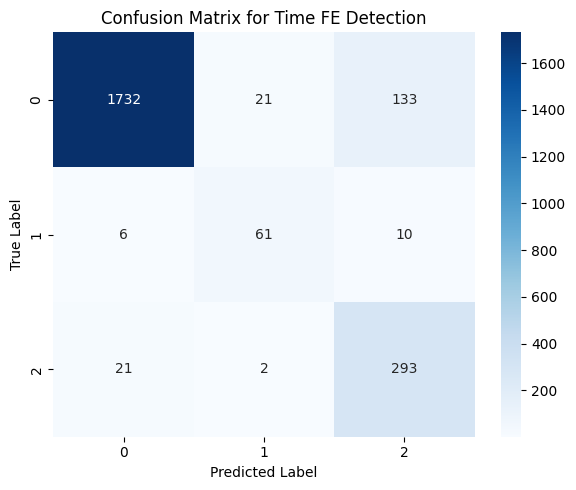

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Time FE Detection')
plt.tight_layout()
plt.show()

In [13]:
import numpy as np

true_np = np.array(all_true_labels)
pred_np = np.array(all_pred_labels)

for label_id, label_name in enumerate(['O', 'B-Place', 'I-Place']):
    total = np.sum(true_np == label_id)
    correct = np.sum((true_np == label_id) & (pred_np == label_id))
    print(f"{label_name} Accuracy: {correct}/{total} = {correct/total:.4f}")

O Accuracy: 1732/1886 = 0.9183
B-Place Accuracy: 61/77 = 0.7922
I-Place Accuracy: 293/316 = 0.9272


In [14]:
import torch
from tqdm import tqdm
def evaluate_model_postprocessed(model, val_dataloader, device):
    model.eval()
    true_labels_all = []
    pred_labels_all = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            raw_preds = torch.argmax(outputs, dim=-1)  # (B, T)
            fixed_preds = fix_bio_predictions2(raw_preds)  # Apply post-processing

            for label_seq, pred_seq, mask in zip(labels, fixed_preds, attention_mask):
                # Remove padding and apply attention mask
                true_seq = [label.item() for label, m in zip(label_seq, mask) if m == 1 and label != -100]
                pred_seq = [pred.item() for pred, m in zip(pred_seq, mask) if m == 1]

                # Convert BIO to binary: 1 if B-Time or I-Time, else 0
                true_binary = [1 if tag in (1, 2) else 0 for tag in true_seq]
                pred_binary = [1 if tag in (1, 2) else 0 for tag in pred_seq[:len(true_seq)]]

                true_labels_all.append(true_binary)
                pred_labels_all.append(pred_binary)

    return evaluate_binary_predictions(true_labels_all, pred_labels_all)

In [15]:
import torch
from tqdm import tqdm

def extract_binary_spans(label_seq):
    spans = []
    start = None
    for i, val in enumerate(label_seq):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            spans.append((start, i - 1))
            start = None
    if start is not None:
        spans.append((start, len(label_seq) - 1))
    return spans

def evaluate_binary_predictions(true_labels_list, pred_labels_list):
    strict_match = 0
    partial_match = 0
    total_spans = 0

    for true_seq, pred_seq in zip(true_labels_list, pred_labels_list):
        true_spans = extract_binary_spans(true_seq)
        pred_spans = extract_binary_spans(pred_seq)
        total_spans += len(true_spans)

        for t_start, t_end in true_spans:
            t_range = set(range(t_start, t_end + 1))
            match_found = False
            for p_start, p_end in pred_spans:
                p_range = set(range(p_start, p_end + 1))
                if t_range == p_range:
                    strict_match += 1
                    match_found = True
                    break
                elif t_range & p_range:
                    match_found = True
            if match_found:
                partial_match += 1

    return {
        "Total Time Elements": total_spans,
        "Strict Matches": strict_match,
        "Partial Matches": partial_match,
        "Strict Accuracy": strict_match / total_spans if total_spans > 0 else 0,
        "Partial Accuracy": partial_match / total_spans if total_spans > 0 else 0
    }

# ⬇️ EVALUATION CODE
def evaluate_model(model, val_dataloader, device):
    model.eval()
    true_labels_all = []
    pred_labels_all = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs, dim=-1)  # shape: (B, T)

            for label_seq, pred_seq, mask in zip(labels, predictions, attention_mask):
                # Remove padding (-100) and apply attention mask
                true_seq = [label.item() for label, m in zip(label_seq, mask) if m == 1 and label != -100]
                pred_seq = [pred.item() for pred, m in zip(pred_seq, mask) if m == 1]

                true_labels_all.append(true_seq)
                pred_labels_all.append(pred_seq[:len(true_seq)])  # Match lengths just in case

    return evaluate_binary_predictions(true_labels_all, pred_labels_all)

In [18]:
results = evaluate_model_postprocessed(model, val_dataloader, device)

print("📊 Post-Processed Evaluation Results:")
for k, v in results.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")

100%|██████████| 450/450 [01:39<00:00,  4.51it/s]

📊 Post-Processed Evaluation Results:
Total Time Elements: 2292
Strict Matches: 1739
Partial Matches: 2101
Strict Accuracy: 0.759
Partial Accuracy: 0.917
